In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [2]:
proximity_trace = pd.read_csv("data/proximityedgestimestamps.csv",sep=";",names=['Timestamp','Dev-1','Dev-2'],skipfooter=1,engine='python')
trace_list = list(zip(list(proximity_trace['Timestamp']),list(proximity_trace['Dev-1']),list(proximity_trace['Dev-2'])))
community_map = pd.read_csv('data/modularityclass.csv',sep=';',index_col=0,names=['Community'],engine='python')

In [3]:
############ Devices DataFrame ############
device_id = list(set(pd.unique(proximity_trace['Dev-1'])).union(set(pd.unique(proximity_trace['Dev-2']))))
devices = pd.DataFrame(data=[(False,0,0,set())]*len(device_id),index=device_id,columns=['Chunk Received','# Broadcasts','# Devices Seen','Devices Seen'])
for idx in range(proximity_trace.shape[0]):
    dev1_idx = proximity_trace.loc[idx, 'Dev-1']
    dev2_idx = proximity_trace.loc[idx, 'Dev-2']
    t1 = set(devices.loc[dev1_idx, 'Devices Seen'])
    t1.add(dev2_idx)
    devices.set_value(dev1_idx,'Devices Seen',t1)
    t2 = set(devices.loc[dev2_idx, 'Devices Seen'])
    t2.add(dev1_idx)
    devices.set_value(dev2_idx,'Devices Seen',t2)
devices['# Devices Seen'] = devices.apply(lambda row: len(row['Devices Seen']),axis=1)
devices['Community'] = community_map
###########################################

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [5]:
########## Broadcast Algorithm 1 ##########
def broadcast_1(devices,source_id,max_broadcasts):
    devices_dict = devices.drop(['# Devices Seen','Devices Seen','Community'],axis=1).T.to_dict('list')
    devices_dict[source_id][0] = True
    device_chunk_count = 1
    time_90 = np.inf
    for idx, trace in enumerate(trace_list):
        dev1 = devices_dict[trace[1]]
        dev2 = devices_dict[trace[2]]
        if dev1[0] and dev1[1] < max_broadcasts and not dev2[0]:
            devices_dict[trace[2]][0] = True
            devices_dict[trace[1]][1] = dev1[1]+1
            device_chunk_count = device_chunk_count + 1
        elif dev2[0] and dev2[1] < max_broadcasts and not dev1[0]:
            devices_dict[trace[1]][0] = True
            devices_dict[trace[2]][1] = dev2[1]+1
            device_chunk_count = device_chunk_count + 1
        if device_chunk_count/len(devices_dict) > 0.9 and time_90 == np.inf:
            time_90 = trace[0]
    return time_90,(device_chunk_count-1)
###########################################

In [5]:
####### Broadcast Algorithm 1 - Analysis 1.a,b #######
source_id = 26
analysis_df_1ab = pd.DataFrame(columns=['K','Time_90','Chunk Copies','% Devices Reached'])

### Uncomment only to recalculate entire analysis
# for idx in range(100):
#     time_90, chunk_copies = broadcast_1(devices,source_id,(idx+1))
#     analysis_df_1ab.loc[idx] = [(idx+1),time_90,chunk_copies,(chunk_copies+1)*100/devices.shape[0]]
#     print(list(analysis_df_1ab.loc[idx]))

# analysis_df_1ab.to_csv('out/Analysis_1ab.csv',index=False)

analysis_df_1ab = pd.read_csv('out/Analysis_1ab.csv')
######################################################

<IPython.core.display.Javascript object>


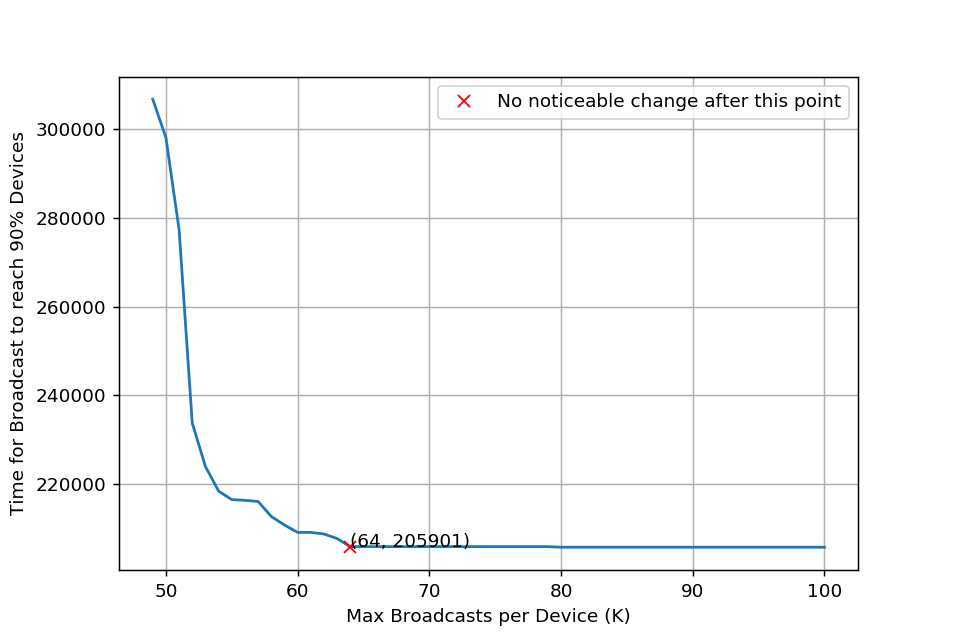

In [6]:
%matplotlib notebook

####### Broadcast Algorithm 1 - Analysis 1.a,b - Plot 1 #######
sns.reset_defaults()
fig, ax = plt.subplots()
plt.plot(analysis_df_1ab['K'],analysis_df_1ab['Time_90'])
cutoff_idx = analysis_df_1ab.shape[0] - np.argmin((np.diff(analysis_df_1ab.loc[analysis_df_1ab['Time_90'] < np.inf,'Time_90']) > -1000)[::-1])
cutoff_pt = (cutoff_idx,int(analysis_df_1ab.loc[cutoff_idx,'Time_90']))
rx = plt.plot(cutoff_pt[0],cutoff_pt[1],'rx')
ax.annotate('({0}, {1})'.format(cutoff_pt[0],cutoff_pt[1]),xy=cutoff_pt,textcoords='data')
plt.ylabel('Time for Broadcast to reach 90% Devices')
plt.xlabel('Max Broadcasts per Device (K)')
plt.legend((rx),('No noticeable change after this point',))
plt.grid()
plt.show()
################################################################

<IPython.core.display.Javascript object>


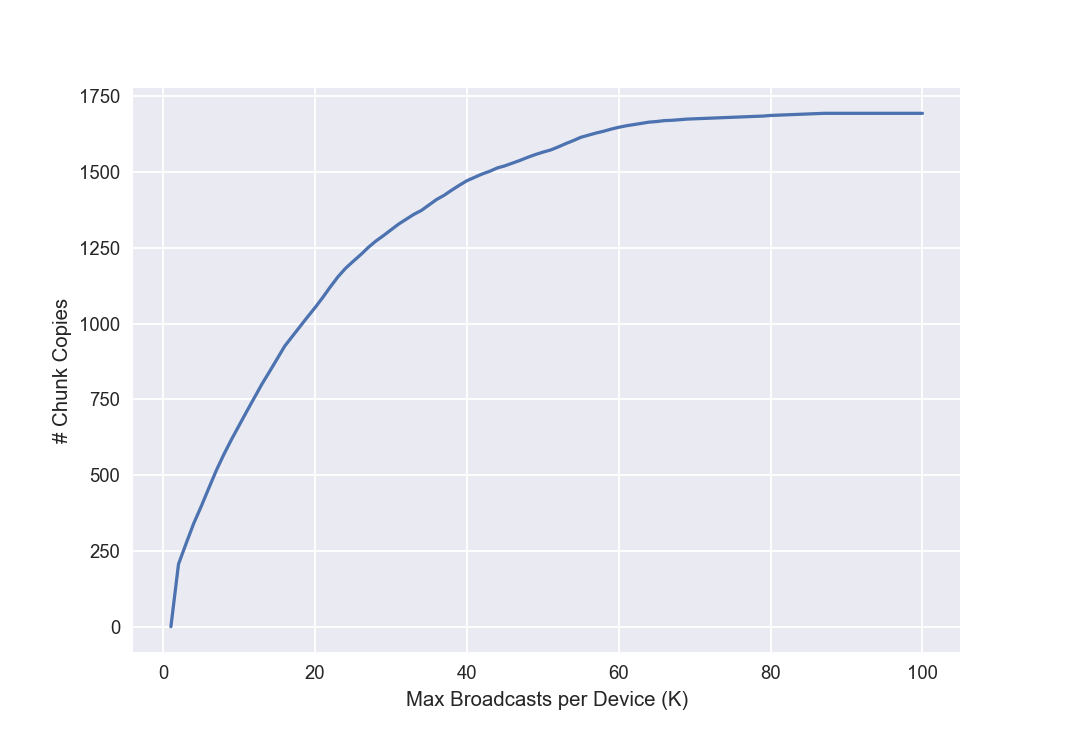

In [7]:
%matplotlib notebook

####### Broadcast Algorithm 1 - Analysis 1.a,b - Plot 2 #######
sns.set()
plt.plot(analysis_df_1ab['K'],analysis_df_1ab['Chunk Copies'])
plt.ylabel('# Chunk Copies')
plt.xlabel('Max Broadcasts per Device (K)')
plt.show()
################################################################

In [6]:
######## Broadcast Algorithm 1 - Analysis 1.c ########
### Uncomment only to change the source device IDs (This needs the analysis to be redone)
source_ids_idx = random.sample(range(devices.shape[0]),100)
source_ids_idx_df = pd.DataFrame(data=source_ids_idx,columns=['id'])
# source_ids_idx_df.to_csv('data/id_1.csv',index=False)

source_ids_idx = list(pd.read_csv('data/id_1.csv')['id'])
source_ids = list(devices.iloc[source_ids_idx].index)
analysis_df_1c = pd.DataFrame(columns=['K','# Above 90% Reach','Time_90_Mean','Time_90_std','Chunk Copies Mean','Chunk Copies Std','% Devices Reached Mean','% Devices Reached Std'])
analysis_df_1c_dump = pd.DataFrame(columns=['K','Source Device ID','Time_90','Chunk Copies','% Devices Reached'])

### Uncomment only to recalculate entire analysis
for idk, k in enumerate(range(40,71)):
    time_90, chunk_copies, devices_reached = [], [], []
    for idx, source_id in enumerate(source_ids):
        time_90_i, chunk_copies_i = broadcast_1(devices,source_id,k)
        analysis_df_1c_dump.loc[(idk*100+idx)] = [k,source_id,time_90_i,chunk_copies_i,(chunk_copies_i+1)*100/devices.shape[0]]
        if (time_90_i != np.inf): time_90.append(time_90_i)
        chunk_copies.append(chunk_copies_i)
        devices_reached.append((chunk_copies_i+1)*100/devices.shape[0])
        print(list(analysis_df_1c_dump.loc[(idk*100+idx)]))
    analysis_df_1c.loc[idk] = [k,len(time_90),np.mean(time_90),np.std(time_90),np.mean(chunk_copies),np.std(chunk_copies),np.mean(devices_reached),np.std(devices_reached)]
    print("#######\n",list(analysis_df_1c.loc[idk]),"\n#######")

# analysis_df_1c.to_csv('out/Analysis_1c.csv',index=False)
# analysis_df_1c_dump.to_csv('out/Analysis_1c_dump.csv',index=False)

# analysis_df_1c = pd.read_csv('out/Analysis_1c.csv')
# analysis_df_1c_dump = pd.read_csv('out/Analysis_1c_dump.csv')
######################################################

[40.0, 3476.0, inf, 942.0, 54.73012188044109]
[40.0, 11071.0, inf, 210.0, 12.2460824143935]
[40.0, 155.0, inf, 1257.0, 73.01218804410911]
[40.0, 1598.0, inf, 169.0, 9.866511897852583]
[40.0, 8344.0, inf, 622.0, 36.15786419036564]
[40.0, 2046.0, inf, 1468.0, 85.25827045850261]
[40.0, 7393.0, inf, 375.0, 21.822402785838655]
[40.0, 8350.0, inf, 622.0, 36.15786419036564]
[40.0, 1325.0, inf, 1360.0, 78.99013348810215]
[40.0, 9334.0, inf, 146.0, 8.53163087637841]
[40.0, 1977.0, inf, 1423.0, 82.64654672083576]
[40.0, 1059.0, inf, 1447.0, 84.0394660475914]
[40.0, 706.0, inf, 947.0, 55.02031340684852]
[40.0, 8757.0, inf, 667.0, 38.7695879280325]
[40.0, 20.0, inf, 1447.0, 84.0394660475914]
[40.0, 2812.0, inf, 1305.0, 75.79802669762043]
[40.0, 2057.0, inf, 1159.0, 67.3244341265235]
[40.0, 11056.0, inf, 171.0, 9.982588508415555]
[40.0, 11560.0, inf, 545.0, 31.688914683691237]
[40.0, 157.0, inf, 1258.0, 73.0702263493906]
[40.0, 762.0, inf, 898.0, 52.17643644805572]
[40.0, 1117.0, inf, 749.0, 43.528

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[41.0, 3476.0, inf, 945.0, 54.904236796285545]
[41.0, 11071.0, inf, 212.0, 12.36215902495647]
[41.0, 155.0, inf, 1265.0, 73.47649448636099]
[41.0, 1598.0, inf, 170.0, 9.924550203134068]
[41.0, 8344.0, inf, 626.0, 36.390017411491584]
[41.0, 2046.0, inf, 1483.0, 86.1288450377249]
[41.0, 7393.0, inf, 377.0, 21.938479396401625]
[41.0, 8350.0, inf, 626.0, 36.390017411491584]
[41.0, 1325.0, inf, 1369.0, 79.51247823563551]
[41.0, 9334.0, inf, 147.0, 8.589669181659895]
[41.0, 1977.0, inf, 1439.0, 83.57515960533952]
[41.0, 1059.0, inf, 1463.0, 84.96807893209518]
[41.0, 706.0, inf, 950.0, 55.19442832269298]
[41.0, 8757.0, inf, 671.0, 39.00174114915844]
[41.0, 20.0, inf, 1461.0, 84.85200232153221]
[41.0, 2812.0, inf, 1312.0, 76.20429483459083]
[41.0, 2057.0, inf, 1167.0, 67.7887405687754]
[41.0, 11056.0, inf, 192.0, 11.201392919326755]
[41.0, 11560.0, inf, 548.0, 31.863029599535693]
[41.0, 157.0, inf, 1266.0, 73.53453279164249]
[41.0, 762.0, inf, 902.0, 52.40858966918166]
[41.0, 1117.0, inf, 755.

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


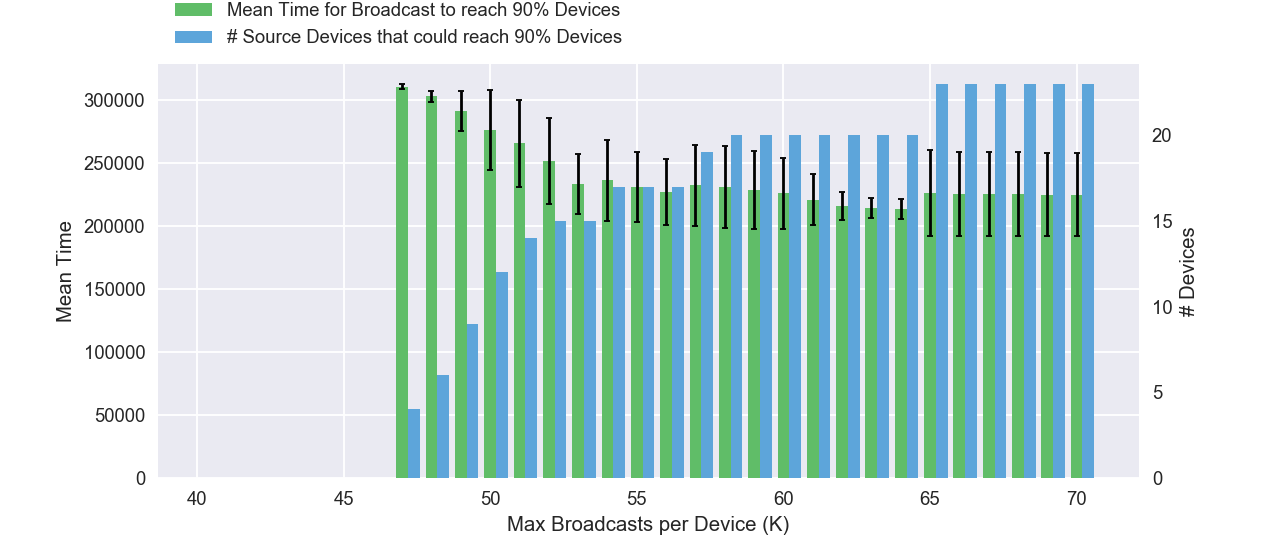

In [9]:
%matplotlib notebook

######### Broadcast Algorithm 1 - Analysis 1.c - Plot 1 ########
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.grid()
r1 = ax1.bar(analysis_df_1c['K'],analysis_df_1c['Time_90_Mean'],width=0.4,color='#60BD68',yerr=analysis_df_1c['Time_90_std'],error_kw=dict(lw=1.5,capsize=1.5,capthick=1))
r2 = ax2.bar(analysis_df_1c['K']+0.4,analysis_df_1c['# Above 90% Reach'],width=0.4,color='#5DA5DA')
ax1.set_ylabel('Mean Time')
ax2.set_ylabel('# Devices')
ax1.set_xlabel('Max Broadcasts per Device (K)')
ax1.legend((r1[0],r2[0]),('Mean Time for Broadcast to reach 90% Devices','# Source Devices that could reach 90% Devices'),bbox_to_anchor=(0,1),loc=3)
plt.show()
################################################################

<IPython.core.display.Javascript object>


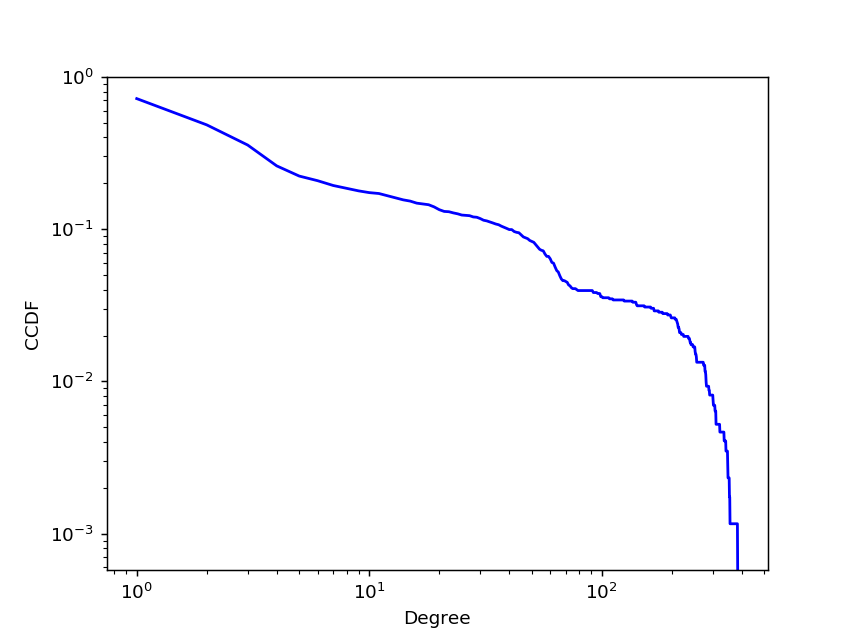

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


In [8]:
%matplotlib notebook

################ CCDF Plot ################
degree_distribution = np.bincount(devices['# Devices Seen'])
s = degree_distribution.sum()
ccdf = 1 - (degree_distribution.cumsum(0)/s)
plt.plot(range(len(ccdf)),ccdf,'b-',markersize=3)
plt.xscale('log')
plt.yscale('log')
plt.ylim([0,1])
plt.ylabel('CCDF')
plt.xlabel('Degree')
plt.show()
###########################################

In [9]:
############## Device Classes #############
def get_device_classes(ccdf,s,l,devices):
    devices_copy = devices.copy()
    super_node_lower = np.argmax(ccdf <= s/100)
    bottom_node_upper = np.argmin(ccdf >= 1-(l/100))-1
    devices_copy.set_value(devices_copy['# Devices Seen'] >= super_node_lower,'Class','Super-Node')
    devices_copy.set_value(devices_copy['# Devices Seen'] <= bottom_node_upper,'Class','Weak-Node')
    return devices_copy
###########################################

In [10]:
############ Gini Coeffiecient ############
def gini(dist):
    sort_dist = np.sort(dist)
    sum_of_absolute_differences = 0
    subsum = 0
    for i, x in enumerate(sort_dist):
        sum_of_absolute_differences += i * x - subsum
        subsum += x
    return np.divide(np.divide(sum_of_absolute_differences,subsum),len(sort_dist))
###########################################

In [11]:
########## Broadcast Algorithm 2 ##########
def broadcast_2(devices,source_id,s,l,x,y):
    devices['Class'] = ['Ordinary']*devices.shape[0]
    devices_copy = get_device_classes(ccdf,s,l,devices)
    devices_dict = devices_copy.drop(['# Devices Seen','Devices Seen','Community'],axis=1).T.to_dict('list')
    devices_dict[source_id][0] = True
    device_chunk_count = 1
    time_90 = np.inf
    for idx, trace in enumerate(trace_list):
        dev1 = devices_dict[trace[1]]
        dev2 = devices_dict[trace[2]]
        if dev1[0] and not dev2[0]:
            prob = 100 if dev2[2] == 'Weak-Node' else x if dev2[2] == 'Super-Node' else y
            if np.random.randint(1,101,size=1) < prob:
                devices_dict[trace[2]][0] = True
                devices_dict[trace[1]][1] = dev1[1]+1
                device_chunk_count = device_chunk_count + 1
        elif dev2[0] and not dev1[0]:
            prob = 100 if dev1[2] == 'Weak-Node' else x if dev1[2] == 'Super-Node' else y
            if np.random.randint(1,101,size=1) < prob:
                devices_dict[trace[1]][0] = True
                devices_dict[trace[2]][1] = dev2[1]+1
                device_chunk_count = device_chunk_count + 1
        if device_chunk_count/len(devices_dict) > 0.9 and time_90 == np.inf:
            time_90 = trace[0]
    devices_copy2 = pd.DataFrame.from_dict(devices_dict,orient='index')
    devices_copy2.columns = ['Chunk Received','# Broadcasts','Class']
    gini_load_super = gini(devices_copy2[devices_copy2['Class'] == 'Super-Node']['# Broadcasts'])
    gini_load_ordinary = gini(devices_copy2[devices_copy2['Class'] == 'Ordinary']['# Broadcasts'])
    gini_load_weak = gini(devices_copy2[devices_copy2['Class'] == 'Weak-Node']['# Broadcasts'])
    mean_load_super = np.mean(devices_copy2[devices_copy2['Class'] == 'Super-Node']['# Broadcasts'])
    mean_load_ordinary = np.mean(devices_copy2[devices_copy2['Class'] == 'Ordinary']['# Broadcasts'])
    mean_load_weak = np.mean(devices_copy2[devices_copy2['Class'] == 'Weak-Node']['# Broadcasts'])
    return gini_load_super,gini_load_ordinary,gini_load_weak,mean_load_super,mean_load_ordinary,mean_load_weak,time_90,(device_chunk_count-1),device_chunk_count*100/devices_copy.shape[0]
###########################################

In [14]:
######## Broadcast Algorithm 2 - Analysis 2.a ########
source_id = 26
s = 0.5
l = 70
T_Prob_Super = np.array([1,2,5,10,20,40,50,60,80,90,95,98,99])
T_Prob_Ordinary = np.array([1,2,5,10,20,40,50,60,80,90,95,98,99])
analysis_df_2a = pd.DataFrame(columns=['T_Prob_Super','T_Prob_Ordinary','Gini_Load_Super','Gini_Load_Ordinary','Gini_Load_Weak','Mean_Load_Super','Mean_Load_Ordinary','Mean_Load_Weak','Time_90','Chunk Copies','% Devices Reached'])

### Uncomment only to recalculate entire analysis
# for ids, tps in enumerate(T_Prob_Super):
#     for ido, tpo in enumerate(T_Prob_Ordinary):
#         analysis_df_2a.loc[ids*len(T_Prob_Super)+ido] = [tps,tpo] + list(broadcast_2(devices,source_id,s,l,tps,tpo))
#         print(list(analysis_df_2a.loc[ids*len(T_Prob_Super)+ido]))

# analysis_df_2a.to_csv('out/Analysis_2a.csv',index=False)

analysis_df_2a = pd.read_csv('out/Analysis_2a.csv')
######################################################

<IPython.core.display.Javascript object>


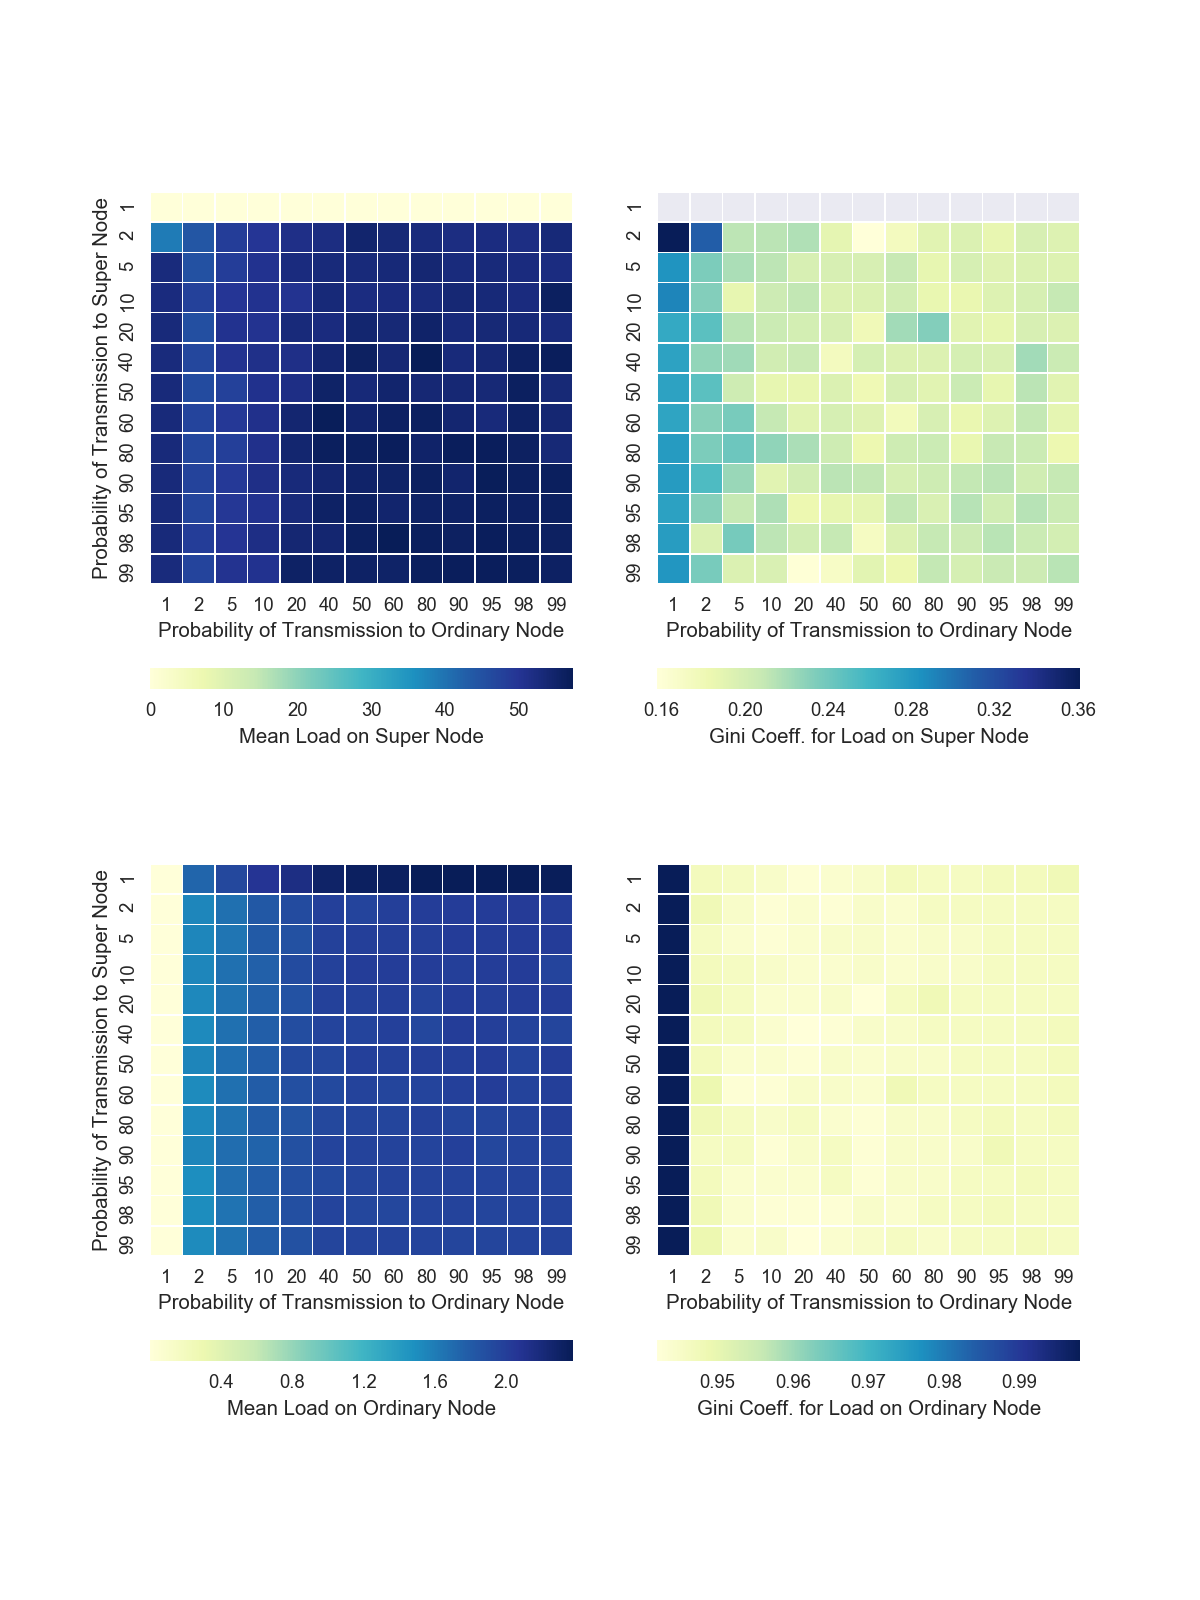

In [15]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.a - Plot 1 ########
analysis_df_2a_pivot1 = analysis_df_2a.pivot('T_Prob_Super','T_Prob_Ordinary','Mean_Load_Super')
analysis_df_2a_pivot2 = analysis_df_2a.pivot('T_Prob_Super','T_Prob_Ordinary','Gini_Load_Super')
analysis_df_2a_pivot3 = analysis_df_2a.pivot('T_Prob_Super','T_Prob_Ordinary','Mean_Load_Ordinary')
analysis_df_2a_pivot4 = analysis_df_2a.pivot('T_Prob_Super','T_Prob_Ordinary','Gini_Load_Ordinary')
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(9,12),nrows=2,ncols=2)
sns.heatmap(analysis_df_2a_pivot1,cmap="YlGnBu",linewidths=.3,ax=ax1,cbar_kws={"orientation": "horizontal","label":"Mean Load on Super Node"})
ax1.set_xlabel("Probability of Transmission to Ordinary Node")
ax1.set_ylabel("Probability of Transmission to Super Node")
sns.heatmap(analysis_df_2a_pivot2,cmap="YlGnBu",linewidths=.3,ax=ax2,cbar_kws={"orientation": "horizontal","label":"Gini Coeff. for Load on Super Node"})
ax2.set_xlabel("Probability of Transmission to Ordinary Node")
ax2.set_ylabel("")
sns.heatmap(analysis_df_2a_pivot3,cmap="YlGnBu",linewidths=.3,ax=ax3,cbar_kws={"orientation": "horizontal","label":"Mean Load on Ordinary Node"})
ax3.set_xlabel("Probability of Transmission to Ordinary Node")
ax3.set_ylabel("Probability of Transmission to Super Node")
sns.heatmap(analysis_df_2a_pivot4,cmap="YlGnBu",linewidths=.3,ax=ax4,cbar_kws={"orientation": "horizontal","label":"Gini Coeff. for Load on Ordinary Node"})
ax4.set_xlabel("Probability of Transmission to Ordinary Node")
ax4.set_ylabel("")
plt.show()
################################################################

<IPython.core.display.Javascript object>


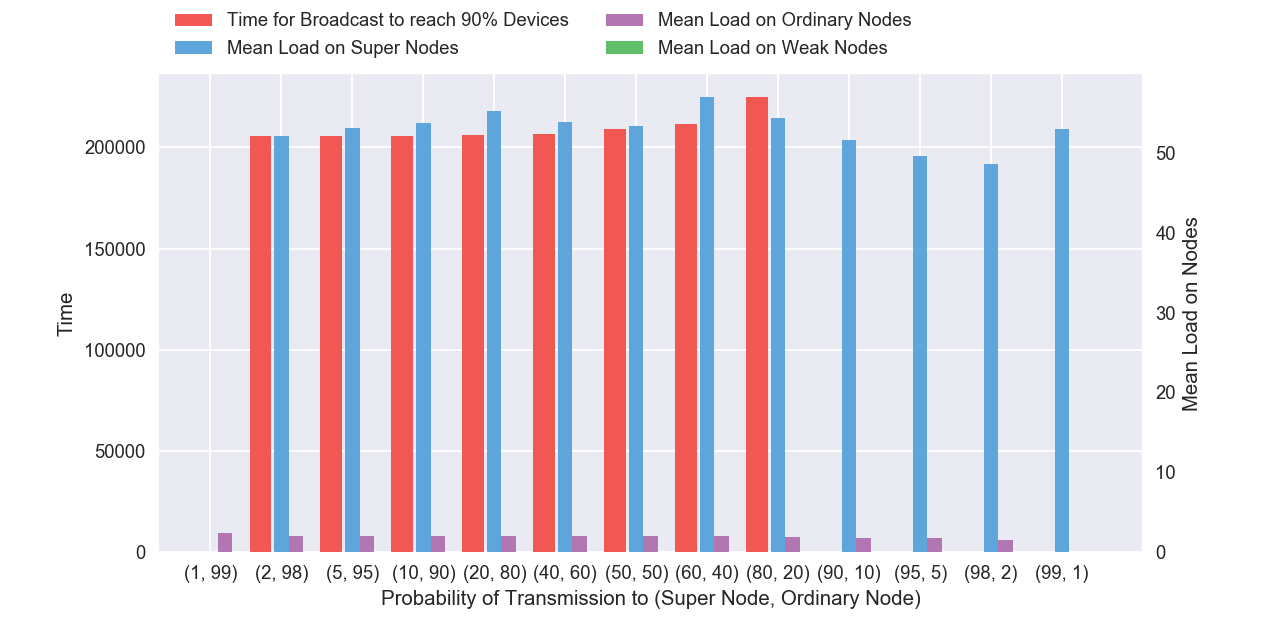

In [16]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.a - Plot 2 ########
analysis_df_2a_ign = analysis_df_2a[(analysis_df_2a["T_Prob_Ordinary"] + analysis_df_2a["T_Prob_Super"]) == 100]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.grid()
x = np.arange(analysis_df_2a_ign['T_Prob_Super'].shape[0])
r1 = ax1.bar(x,analysis_df_2a_ign['Time_90'],width=0.3,color='#F15854')
r2 = ax2.bar(x+0.3,analysis_df_2a_ign['Mean_Load_Super'],width=0.2,color='#5DA5DA')
r3 = ax2.bar(x+0.5,analysis_df_2a_ign['Mean_Load_Ordinary'],width=0.2,color='#B276B2')
r4 = ax2.bar(x+0.7,analysis_df_2a_ign['Mean_Load_Weak'],width=0.2,color='#60BD68')
ax1.set_xticks(x+0.3)
ticklabels = [(a,b) for a,b in zip(list(analysis_df_2a_ign['T_Prob_Super']),list(analysis_df_2a_ign['T_Prob_Ordinary']))]
ax1.set_xticklabels(ticklabels)
ax1.set_xlabel('Probability of Transmission to (Super Node, Ordinary Node)')
ax1.set_ylabel('Time')
ax2.set_ylabel('Mean Load on Nodes')
ax1.legend((r1[0],r2[0],r3[0],r4[0]),('Time for Broadcast to reach 90% Devices','Mean Load on Super Nodes','Mean Load on Ordinary Nodes','Mean Load on Weak Nodes'),bbox_to_anchor=(0,1),loc=3,ncol=2)
plt.show()
################################################################

<IPython.core.display.Javascript object>


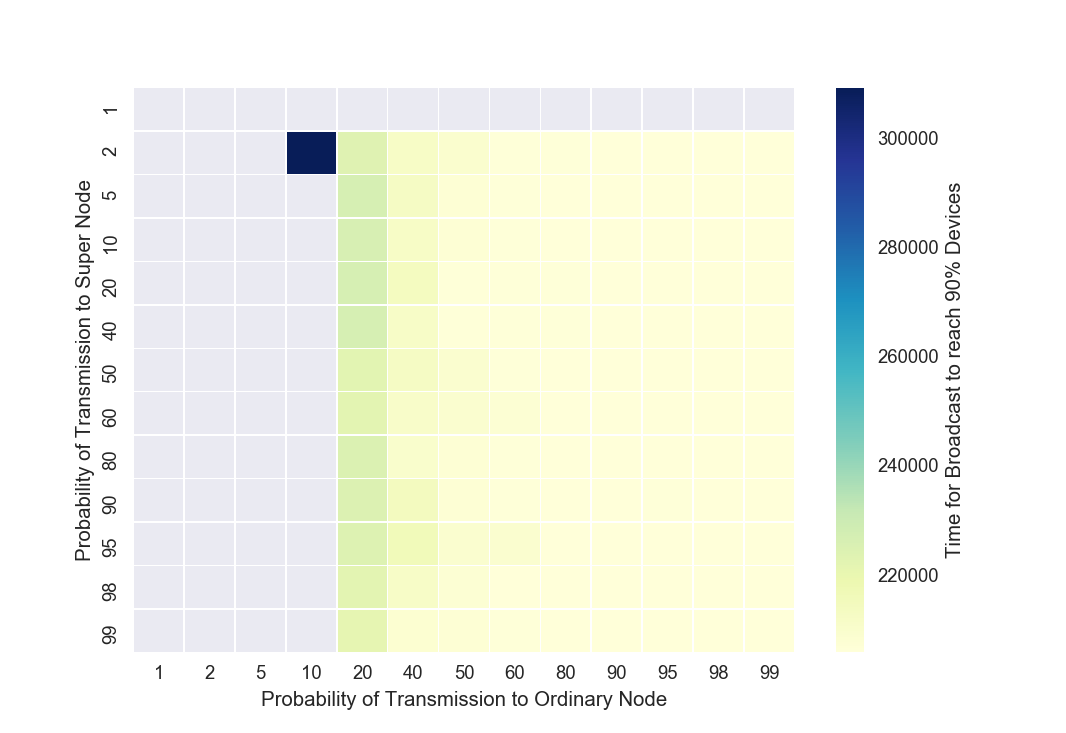

In [17]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.a - Plot 3 ########
analysis_df_2a_pivot5 = analysis_df_2a.pivot('T_Prob_Super','T_Prob_Ordinary','Time_90')
inf_mask = np.isinf(analysis_df_2a_pivot5)
fig,ax = plt.subplots()
sns.heatmap(analysis_df_2a_pivot5,vmin=np.min(np.min(analysis_df_2a_pivot5[~inf_mask])),vmax=np.max(np.max(analysis_df_2a_pivot5[~inf_mask])),mask=inf_mask,cmap="YlGnBu",linewidths=.3,ax=ax,cbar_kws={"orientation": "vertical","label":"Time for Broadcast to reach 90% Devices"})
ax.set_xlabel("Probability of Transmission to Ordinary Node")
ax.set_ylabel("Probability of Transmission to Super Node")
plt.show()
################################################################

In [ ]:
######## Broadcast Algorithm 2 - Analysis 2.b ########
### Uncomment only to change the source device IDs (This needs the analysis to be redone)
source_ids_idx = random.sample(range(devices.shape[0]),100)
source_ids_idx_df = pd.DataFrame(data=source_ids_idx,columns=['id'])
# source_ids_idx_df.to_csv('data/id_2.csv',index=False)

source_ids_idx = list(pd.read_csv('data/id_2.csv')['id'])
source_ids = list(devices.iloc[source_ids_idx].index)
s = 0.5
l = 70
T_Prob_Super = np.array([1,2,5,10,20,40,50,60,80,90,95,98,99])
T_Prob_Ordinary = np.array([1,2,5,10,20,40,50,60,80,90,95,98,99])
analysis_df_2b = pd.DataFrame(columns=['T_Prob_Super','T_Prob_Ordinary','Mean_Gini_Load_Super','Mean_Gini_Load_Ordinary','Mean_Gini_Load_Weak','Mean_Mean_Load_Super','Mean_Mean_Load_Ordinary','Mean_Mean_Load_Weak','# Above 90% Reach','Time_90_Mean','Time_90_Std','Chunk Copies','% Devices Reached'])

### Uncomment only to recalculate entire analysis
for ids, tps in enumerate(T_Prob_Super):
    for ido, tpo in enumerate(T_Prob_Ordinary):
        ginild_super, ginild_ordinary, ginild_weak, meanld_super, meanld_ordinary, meanld_weak, time_90, chunk_copies, dev_reached = [], [], [], [], [], [], [], [], []
        for idd, source_id in enumerate(source_ids):
            gini_s,gini_o,gini_w,mean_s,mean_o,mean_w,t,chnk,dev = broadcast_2(devices,source_id,s,l,tps,tpo)
            if(t != np.inf): time_90.append(t)
            ginild_super.append(gini_s)
            ginild_ordinary.append(gini_o)
            ginild_weak.append(gini_w)
            meanld_super.append(mean_s)
            meanld_ordinary.append(mean_o)
            meanld_weak.append(mean_w)
            chunk_copies.append(chnk)
            dev_reached.append(dev)
        analysis_df_2b.loc[ids*len(T_Prob_Super)+ido] = [tps,tpo,np.nanmean(ginild_super),np.nanmean(ginild_ordinary),np.nanmean(ginild_weak),np.nanmean(meanld_super),np.nanmean(meanld_ordinary),np.nanmean(meanld_weak),len(time_90),np.mean(time_90),np.std(time_90),np.mean(chunk_copies),np.mean(dev_reached)]
        print(list(analysis_df_2b.loc[ids*len(T_Prob_Super)+ido]))

# analysis_df_2b.to_csv('out/Analysis_2b.csv',index=False)

# analysis_df_2b = pd.read_csv('out/Analysis_2b.csv')
######################################################

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:1

[1.0, 1.0, 0.8888888888888888, 0.9983471074380166, nan, 0.08777777777777779, 0.0024793388429752068, 0.0, 0.0, nan, nan, 2.29, 0.19094602437608818]
[1.0, 2.0, 0.8888888888888888, 0.9554652309159261, 0.9987514739543594, 0.08888888888888889, 0.24776859504132231, 0.00016230838593327322, 0.0, nan, nan, 150.88, 8.81485780615206]
[1.0, 5.0, 0.8888888888888888, 0.9549111323828833, 0.9987294040495123, 0.08666666666666666, 0.4027933884297521, 0.0002795311091073039, 0.0, nan, nan, 244.78, 14.26465467208358]
[1.0, 10.0, 0.8888888888888888, 0.9597275073556827, 0.998346859032161, 0.08888888888888889, 0.5826446280991735, 0.0005410279531109107, 0.0, nan, nan, 353.9, 20.597794544399306]
[1.0, 20.0, 0.8888888888888888, 0.9611449552478357, 0.9981773881012221, 0.09777777777777778, 0.8415702479338844, 0.0008566275924256087, 0.0, nan, nan, 510.98, 29.71445153801509]
[1.0, 40.0, 0.8888888888888888, 0.9604194315731411, 0.997967566948631, 0.10555555555555556, 1.1837685950413224, 0.0013435527502254282, 0.0, nan

<IPython.core.display.Javascript object>


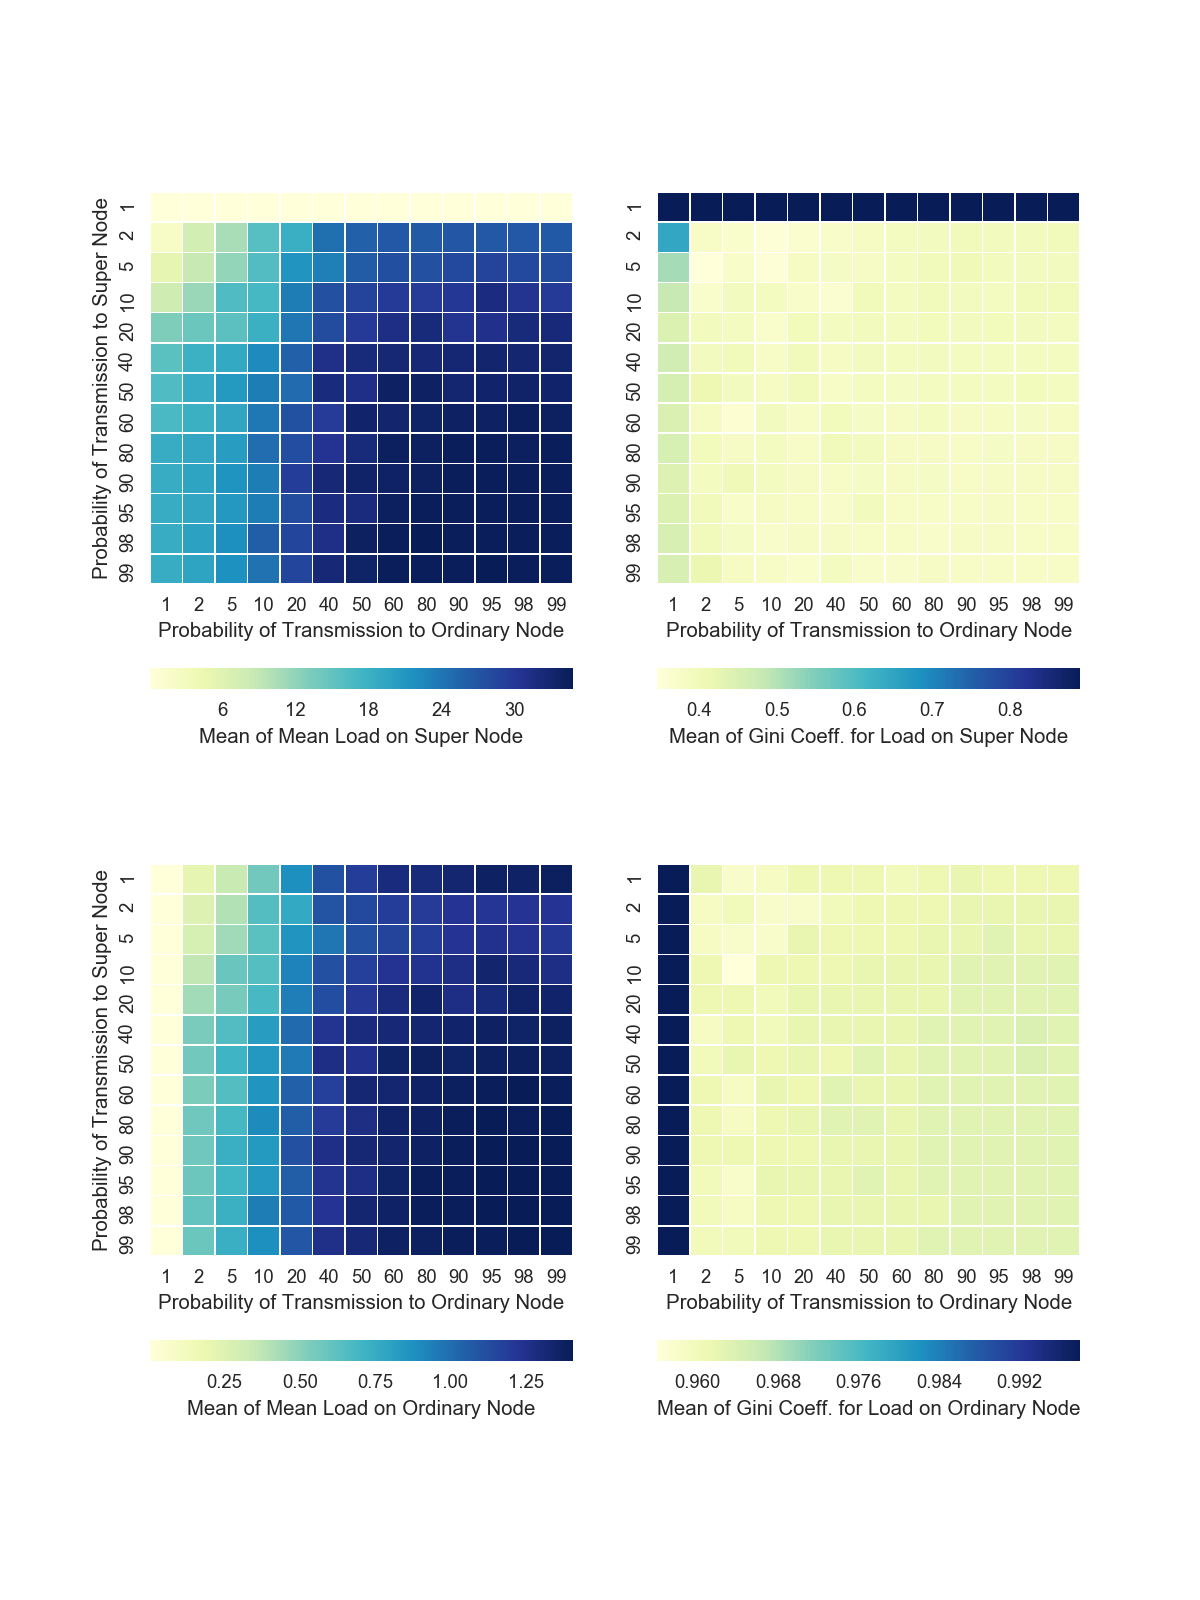

In [9]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.b - Plot 1 ########
analysis_df_2b_pivot1 = analysis_df_2b.pivot('T_Prob_Super','T_Prob_Ordinary','Mean_Mean_Load_Super')
analysis_df_2b_pivot2 = analysis_df_2b.pivot('T_Prob_Super','T_Prob_Ordinary','Mean_Gini_Load_Super')
analysis_df_2b_pivot3 = analysis_df_2b.pivot('T_Prob_Super','T_Prob_Ordinary','Mean_Mean_Load_Ordinary')
analysis_df_2b_pivot4 = analysis_df_2b.pivot('T_Prob_Super','T_Prob_Ordinary','Mean_Gini_Load_Ordinary')
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(9,12),nrows=2,ncols=2)
sns.heatmap(analysis_df_2b_pivot1,cmap="YlGnBu",linewidths=.3,ax=ax1,cbar_kws={"orientation": "horizontal","label":"Mean of Mean Load on Super Node"})
ax1.set_xlabel("Probability of Transmission to Ordinary Node")
ax1.set_ylabel("Probability of Transmission to Super Node")
sns.heatmap(analysis_df_2b_pivot2,cmap="YlGnBu",linewidths=.3,ax=ax2,cbar_kws={"orientation": "horizontal","label":"Mean of Gini Coeff. for Load on Super Node"})
ax2.set_xlabel("Probability of Transmission to Ordinary Node")
ax2.set_ylabel("")
sns.heatmap(analysis_df_2b_pivot3,cmap="YlGnBu",linewidths=.3,ax=ax3,cbar_kws={"orientation": "horizontal","label":"Mean of Mean Load on Ordinary Node"})
ax3.set_xlabel("Probability of Transmission to Ordinary Node")
ax3.set_ylabel("Probability of Transmission to Super Node")
sns.heatmap(analysis_df_2b_pivot4,cmap="YlGnBu",linewidths=.3,ax=ax4,cbar_kws={"orientation": "horizontal","label":"Mean of Gini Coeff. for Load on Ordinary Node"})
ax4.set_xlabel("Probability of Transmission to Ordinary Node")
ax4.set_ylabel("")
plt.show()
################################################################

<IPython.core.display.Javascript object>


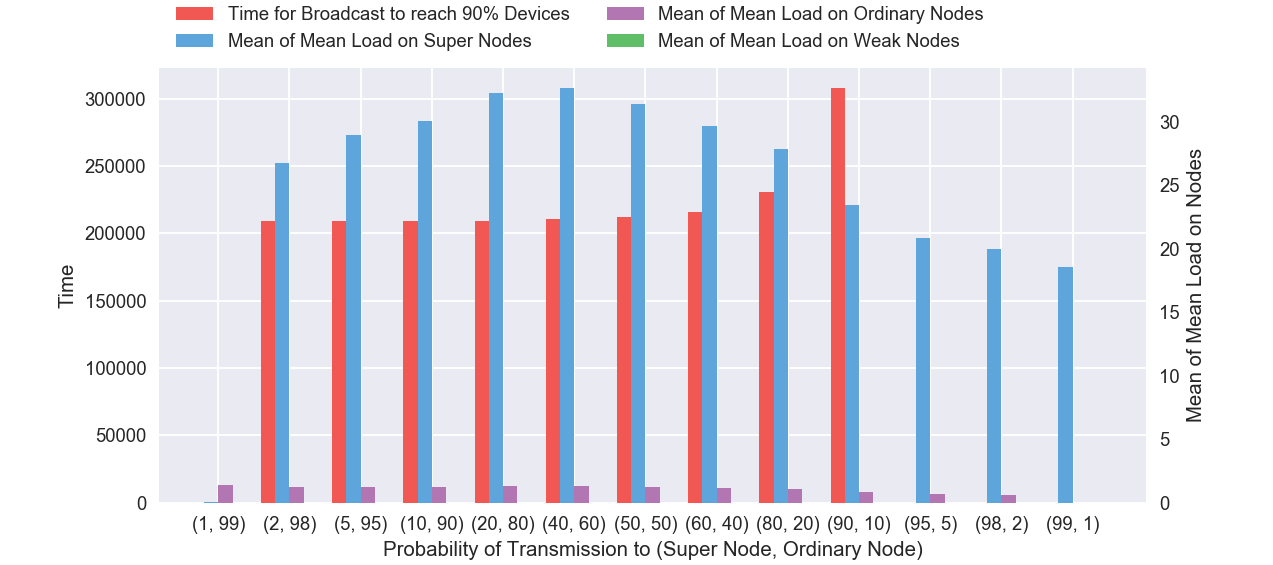

In [11]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.b - Plot 2 ########
analysis_df_2b_ign = analysis_df_2b[(analysis_df_2b["T_Prob_Ordinary"] + analysis_df_2b["T_Prob_Super"]) == 100]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.grid()
x = np.arange(analysis_df_2b_ign['T_Prob_Super'].shape[0])
r1 = ax1.bar(x,analysis_df_2b_ign['Time_90_Mean'],width=0.2,color='#F15854')
r2 = ax2.bar(x+0.2,analysis_df_2b_ign['Mean_Mean_Load_Super'],width=0.2,color='#5DA5DA')
r3 = ax2.bar(x+0.4,analysis_df_2b_ign['Mean_Mean_Load_Ordinary'],width=0.2,color='#B276B2')
r4 = ax2.bar(x+0.6,analysis_df_2b_ign['Mean_Mean_Load_Weak'],width=0.2,color='#60BD68')
ax1.set_xticks(x+0.3)
ticklabels = [(a,b) for a,b in zip(list(analysis_df_2b_ign['T_Prob_Super']),list(analysis_df_2b_ign['T_Prob_Ordinary']))]
ax1.set_xticklabels(ticklabels)
ax1.set_xlabel('Probability of Transmission to (Super Node, Ordinary Node)')
ax1.set_ylabel('Time')
ax2.set_ylabel('Mean of Mean Load on Nodes')
ax1.legend((r1[0],r2[0],r3[0],r4[0]),('Time for Broadcast to reach 90% Devices','Mean of Mean Load on Super Nodes','Mean of Mean Load on Ordinary Nodes','Mean of Mean Load on Weak Nodes'),bbox_to_anchor=(0,1),loc=3,ncol=2)
plt.show()
################################################################

<IPython.core.display.Javascript object>


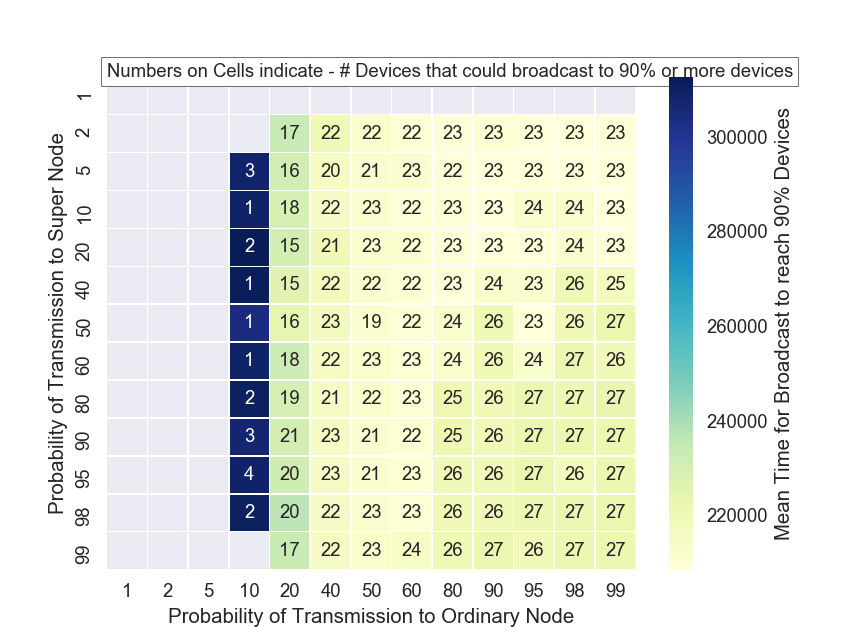

In [24]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.b - Plot 3 ########
analysis_df_2b_pivot5 = analysis_df_2b.pivot('T_Prob_Super','T_Prob_Ordinary','Time_90_Mean')
analysis_df_2b_pivot6 = analysis_df_2b.pivot('T_Prob_Super','T_Prob_Ordinary','# Above 90% Reach')
inf_mask = np.isinf(analysis_df_2b_pivot5)
fig,ax = plt.subplots()
sns.heatmap(analysis_df_2b_pivot5,annot=analysis_df_2b_pivot6,vmin=np.min(np.min(analysis_df_2b_pivot5[~inf_mask])),vmax=np.max(np.max(analysis_df_2b_pivot5[~inf_mask])),mask=inf_mask,cmap="YlGnBu",linewidths=.3,ax=ax,cbar_kws={"orientation": "vertical","label":"Mean Time for Broadcast to reach 90% Devices"})
ax.set_xlabel("Probability of Transmission to Ordinary Node")
ax.set_ylabel("Probability of Transmission to Super Node")
ax.annotate('Numbers on Cells indicate - # Devices that could broadcast to 90% or more devices',xy=(0,13),bbox=dict(boxstyle='square',facecolor='white'))
plt.show()
################################################################

In [8]:
######## Broadcast Algorithm 2 - Analysis 2.c ########
source_id = 26
s_list = [1,2,5,10,20,30]
l = 70
T_Prob_Super = np.array([1,2,5,10,20,40,50,60,80,90,95,98,99])
analysis_df_2c = pd.DataFrame(columns=['S','T_Prob_Super','T_Prob_Ordinary','Gini_Load_Super','Gini_Load_Ordinary','Gini_Load_Weak','Mean_Load_Super','Mean_Load_Ordinary','Mean_Load_Weak','Time_90','Chunk Copies','% Devices Reached'])

### Uncomment only to recalculate entire analysis
# for idx, s in enumerate(s_list):
#     for idt, tps in enumerate(T_Prob_Super):
#         analysis_df_2c.loc[idx*len(s_list)+idt] = [s,tps,100-tps] + list(broadcast_2(devices,source_id,s,l,tps,100-tps))
#         print(list(analysis_df_2c.loc[idx*len(s_list)+idt]))

# analysis_df_2c.to_csv('out/Analysis_2c.csv',index=False)

analysis_df_2c = pd.read_csv('out/Analysis_2c.csv')
######################################################

<IPython.core.display.Javascript object>


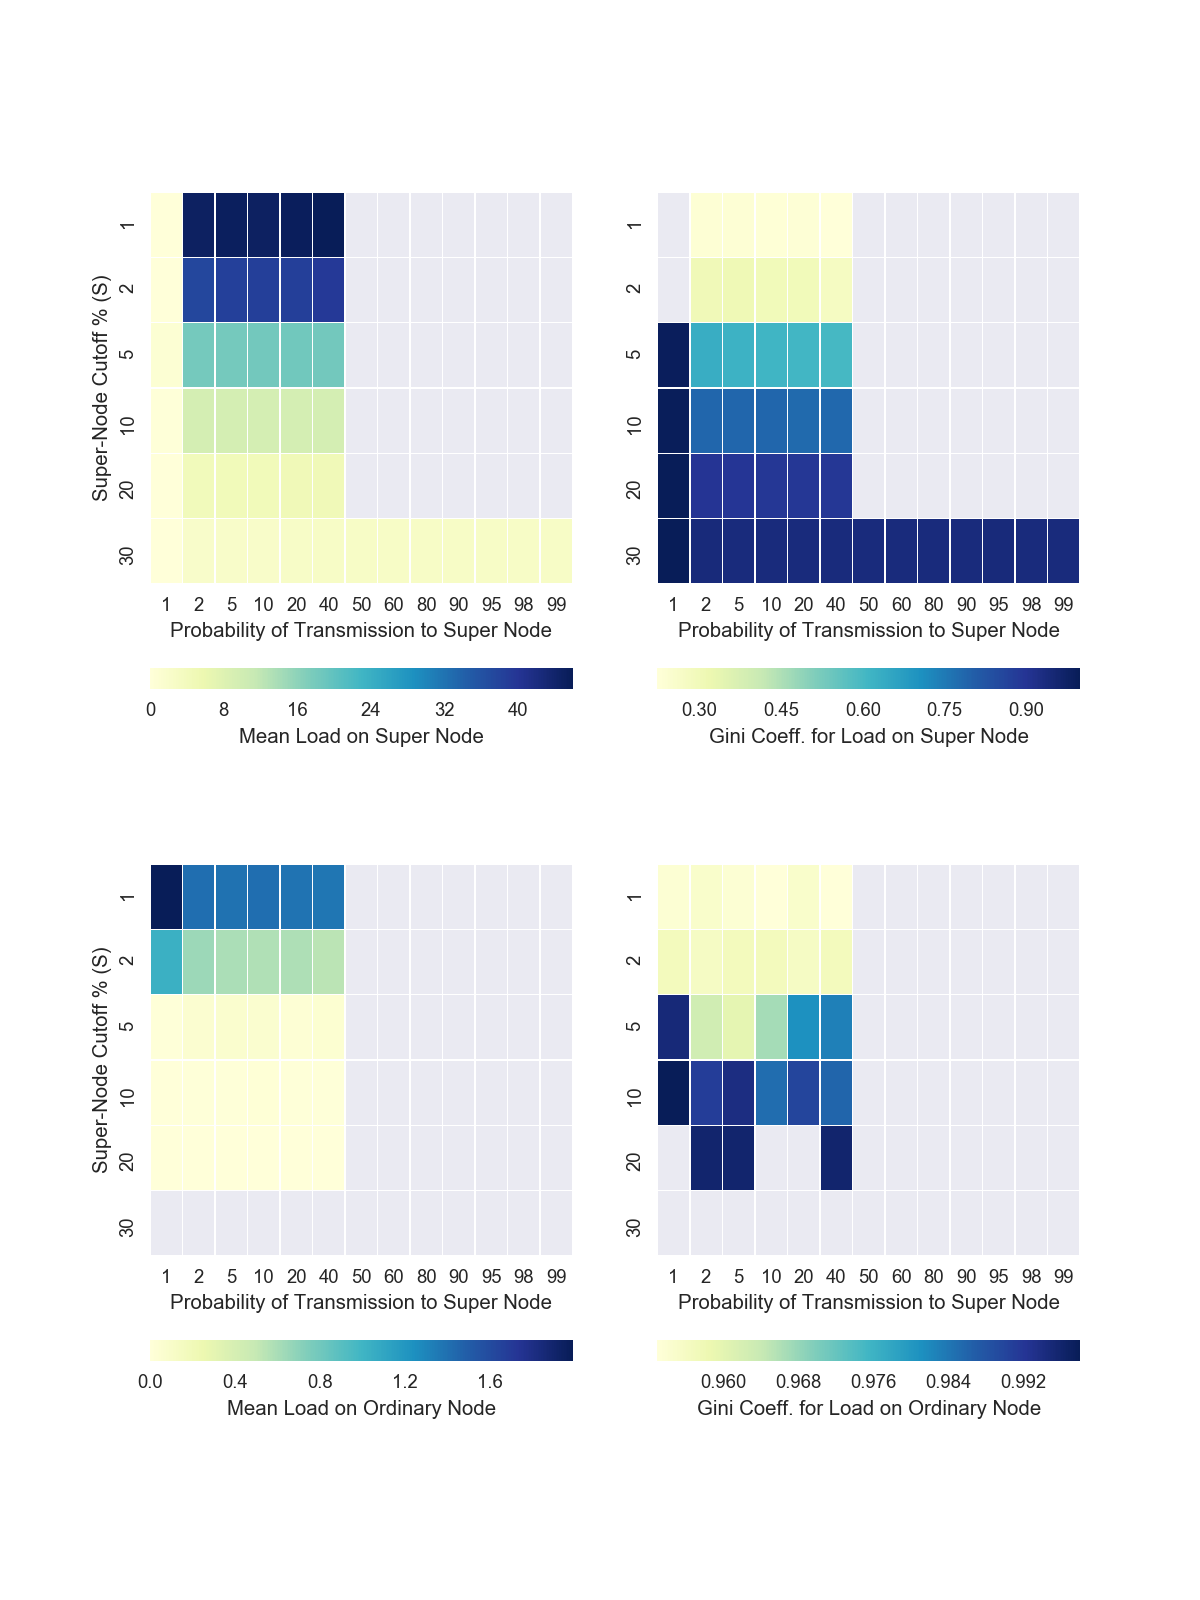

In [9]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.c - Plot 1 ########
analysis_df_2c_pivot1 = analysis_df_2c.pivot('S','T_Prob_Super','Mean_Load_Super')
analysis_df_2c_pivot2 = analysis_df_2c.pivot('S','T_Prob_Super','Gini_Load_Super')
analysis_df_2c_pivot3 = analysis_df_2c.pivot('S','T_Prob_Super','Mean_Load_Ordinary')
analysis_df_2c_pivot4 = analysis_df_2c.pivot('S','T_Prob_Super','Gini_Load_Ordinary')
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(9,12),nrows=2,ncols=2)
sns.heatmap(analysis_df_2c_pivot1,cmap="YlGnBu",linewidths=.3,ax=ax1,cbar_kws={"orientation": "horizontal","label":"Mean Load on Super Node"})
ax1.set_xlabel("Probability of Transmission to Super Node")
ax1.set_ylabel("Super-Node Cutoff % (S)")
sns.heatmap(analysis_df_2c_pivot2,cmap="YlGnBu",linewidths=.3,ax=ax2,cbar_kws={"orientation": "horizontal","label":"Gini Coeff. for Load on Super Node"})
ax2.set_xlabel("Probability of Transmission to Super Node")
ax2.set_ylabel("")
sns.heatmap(analysis_df_2c_pivot3,cmap="YlGnBu",linewidths=.3,ax=ax3,cbar_kws={"orientation": "horizontal","label":"Mean Load on Ordinary Node"})
ax3.set_xlabel("Probability of Transmission to Super Node")
ax3.set_ylabel("Super-Node Cutoff % (S)")
sns.heatmap(analysis_df_2c_pivot4,cmap="YlGnBu",linewidths=.3,ax=ax4,cbar_kws={"orientation": "horizontal","label":"Gini Coeff. for Load on Ordinary Node"})
ax4.set_xlabel("Probability of Transmission to Super Node")
ax4.set_ylabel("")
plt.show()
################################################################

<IPython.core.display.Javascript object>


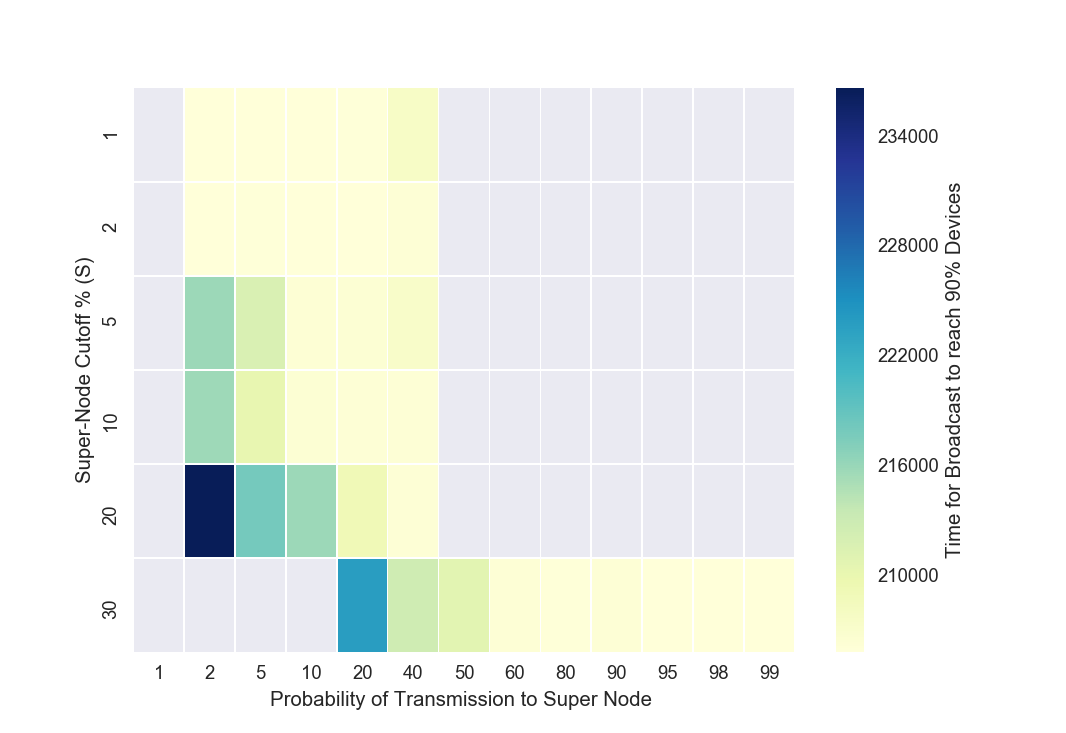

In [22]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.c - Plot 2 ########
analysis_df_2c_pivot5 = analysis_df_2c.pivot('S','T_Prob_Super','Time_90')
inf_mask = np.isinf(analysis_df_2c_pivot5)
fig,ax = plt.subplots()
sns.heatmap(analysis_df_2c_pivot5,vmin=np.min(np.min(analysis_df_2c_pivot5[~inf_mask])),vmax=np.max(np.max(analysis_df_2c_pivot5[~inf_mask])),mask=inf_mask,cmap="YlGnBu",linewidths=.3,ax=ax,cbar_kws={"orientation": "vertical","label":"Time for Broadcast to reach 90% Devices"})
ax.set_ylabel("Super-Node Cutoff % (S)")
ax.set_xlabel("Probability of Transmission to Super Node ")
plt.show()
################################################################

In [23]:
######## Broadcast Algorithm 2 - Analysis 2.d ########
source_id = 26
s = 0.5
l_list = [1,5,10,20,40,50,60,80,90,95,99]
T_Prob_Super = np.array([1,2,5,10,20,40,50,60,80,90,95,98,99])
analysis_df_2d = pd.DataFrame(columns=['L','T_Prob_Super','T_Prob_Ordinary','Gini_Load_Super','Gini_Load_Ordinary','Gini_Load_Weak','Mean_Load_Super','Mean_Load_Ordinary','Mean_Load_Weak','Time_90','Chunk Copies','% Devices Reached'])

### Uncomment only to recalculate entire analysis
# for idx, l in enumerate(l_list):
#     for idt, tps in enumerate(T_Prob_Super):
#         analysis_df_2d.loc[idx*len(l_list)+idt] = [l,tps,100-tps] + list(broadcast_2(devices,source_id,s,l,tps,100-tps))
#         print(list(analysis_df_2d.loc[idx*len(l_list)+idt]))

# analysis_df_2d.to_csv('out/Analysis_2d.csv',index=False)

analysis_df_2d = pd.read_csv('out/Analysis_2d.csv')
######################################################

<IPython.core.display.Javascript object>


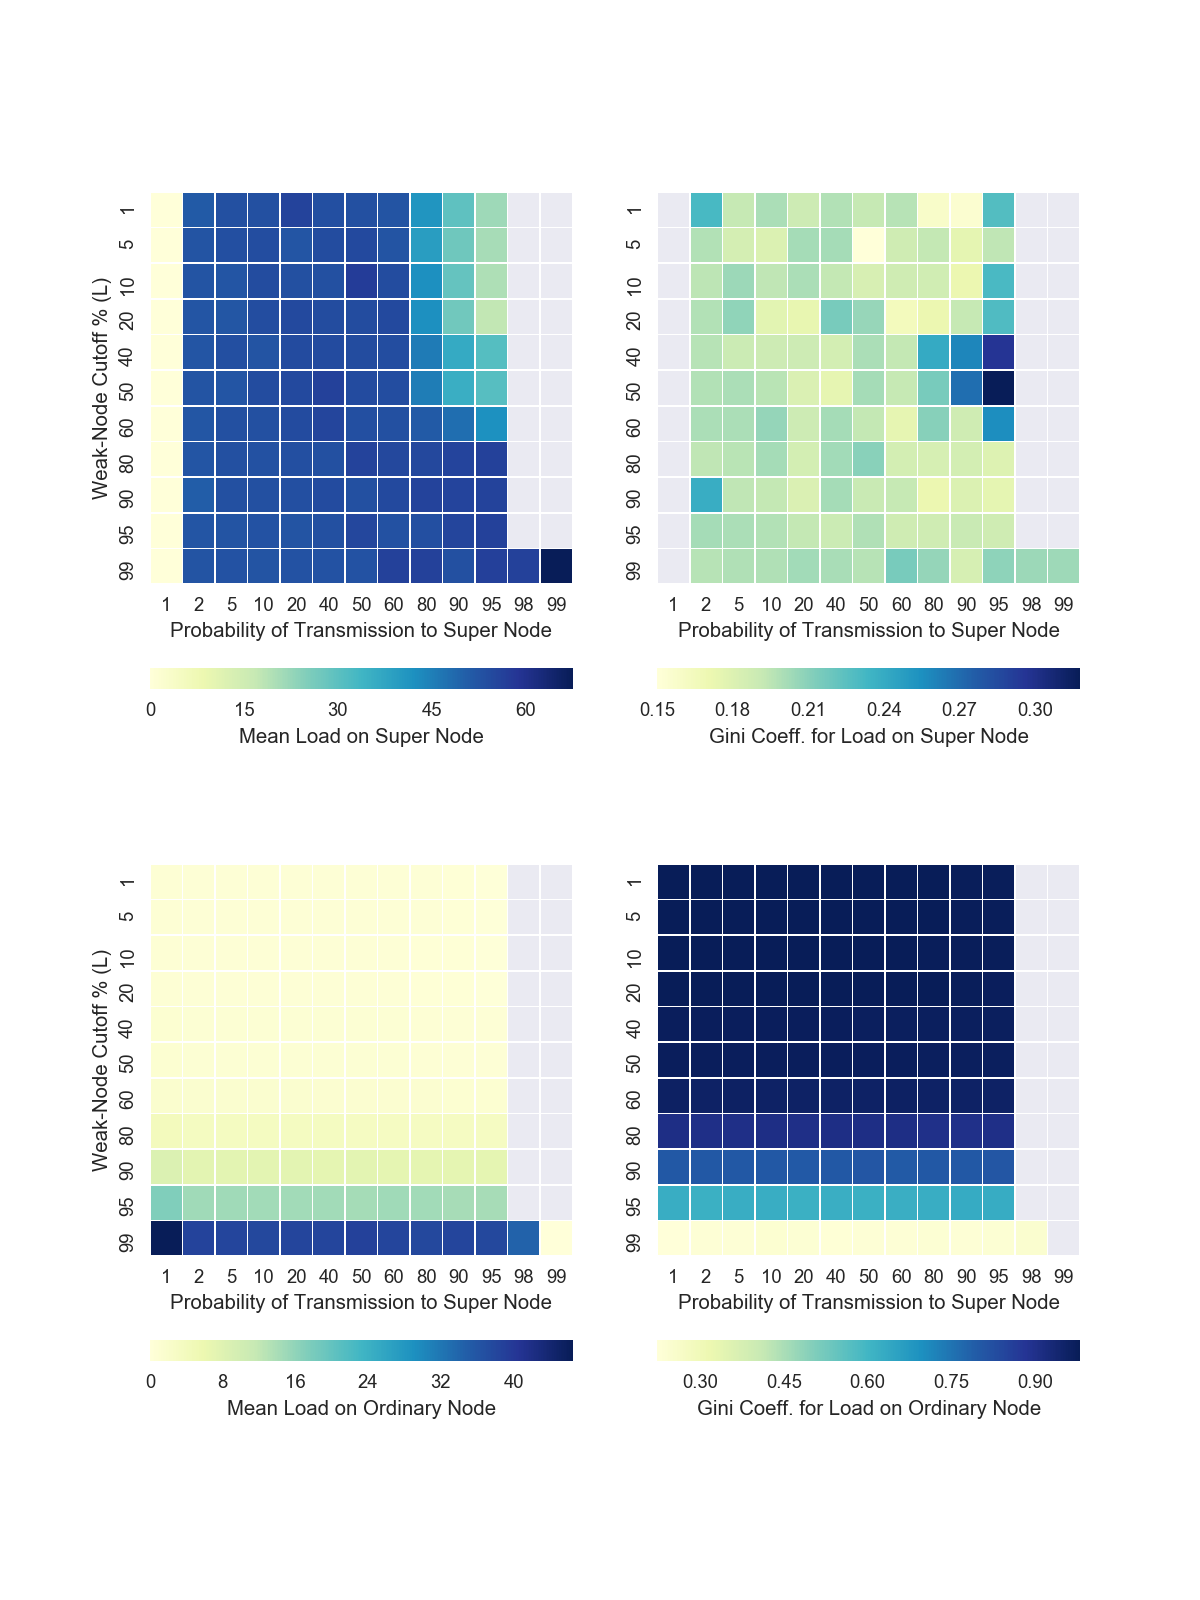

In [13]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.d - Plot 1 ########
analysis_df_2d_pivot1 = analysis_df_2d.pivot('L','T_Prob_Super','Mean_Load_Super')
analysis_df_2d_pivot2 = analysis_df_2d.pivot('L','T_Prob_Super','Gini_Load_Super')
analysis_df_2d_pivot3 = analysis_df_2d.pivot('L','T_Prob_Super','Mean_Load_Ordinary')
analysis_df_2d_pivot4 = analysis_df_2d.pivot('L','T_Prob_Super','Gini_Load_Ordinary')
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(9,12),nrows=2,ncols=2)
sns.heatmap(analysis_df_2d_pivot1,cmap="YlGnBu",linewidths=.3,ax=ax1,cbar_kws={"orientation": "horizontal","label":"Mean Load on Super Node"})
ax1.set_xlabel("Probability of Transmission to Super Node")
ax1.set_ylabel("Weak-Node Cutoff % (L)")
sns.heatmap(analysis_df_2d_pivot2,cmap="YlGnBu",linewidths=.3,ax=ax2,cbar_kws={"orientation": "horizontal","label":"Gini Coeff. for Load on Super Node"})
ax2.set_xlabel("Probability of Transmission to Super Node")
ax2.set_ylabel("")
sns.heatmap(analysis_df_2d_pivot3,cmap="YlGnBu",linewidths=.3,ax=ax3,cbar_kws={"orientation": "horizontal","label":"Mean Load on Ordinary Node"})
ax3.set_xlabel("Probability of Transmission to Super Node")
ax3.set_ylabel("Weak-Node Cutoff % (L)")
sns.heatmap(analysis_df_2d_pivot4,cmap="YlGnBu",linewidths=.3,ax=ax4,cbar_kws={"orientation": "horizontal","label":"Gini Coeff. for Load on Ordinary Node"})
ax4.set_xlabel("Probability of Transmission to Super Node")
ax4.set_ylabel("")
plt.show()
################################################################

<IPython.core.display.Javascript object>


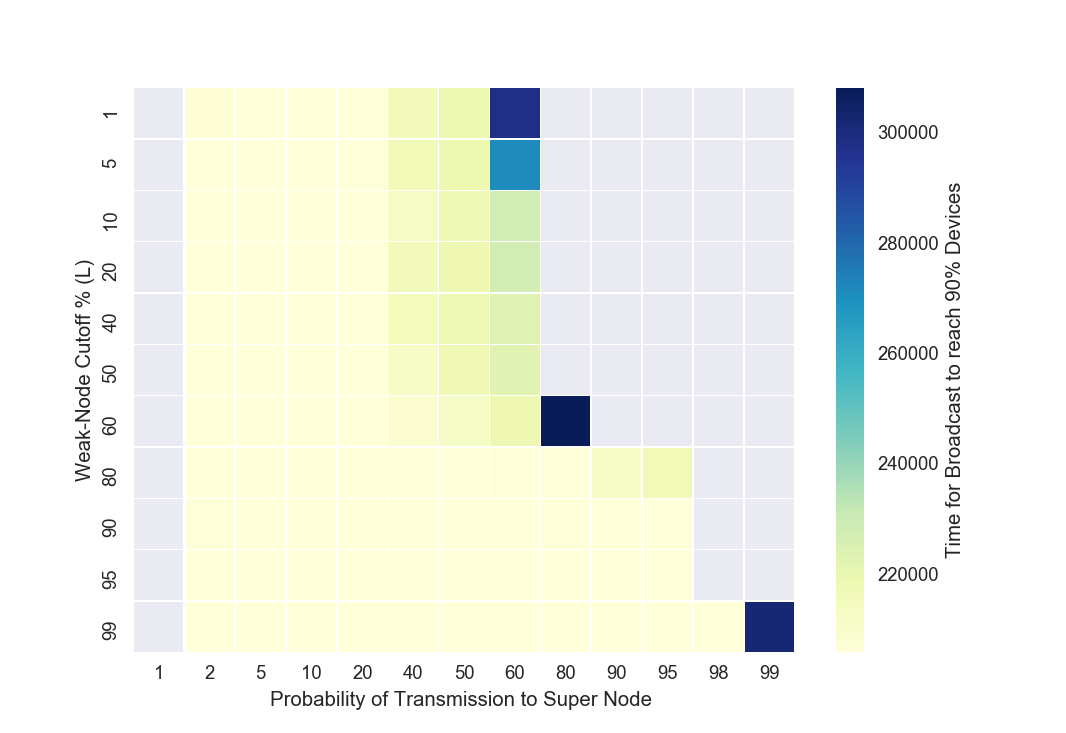

In [25]:
%matplotlib notebook

######### Broadcast Algorithm 2 - Analysis 2.d - Plot 2 ########
analysis_df_2d_pivot5 = analysis_df_2d.pivot('L','T_Prob_Super','Time_90')
inf_mask = np.isinf(analysis_df_2d_pivot5)
fig,ax = plt.subplots()
sns.heatmap(analysis_df_2d_pivot5,vmin=np.min(np.min(analysis_df_2d_pivot5[~inf_mask])),vmax=np.max(np.max(analysis_df_2d_pivot5[~inf_mask])),mask=inf_mask,cmap="YlGnBu",linewidths=.3,ax=ax,cbar_kws={"orientation": "vertical","label":"Time for Broadcast to reach 90% Devices"})
ax.set_ylabel("Weak-Node Cutoff % (L)")
ax.set_xlabel("Probability of Transmission to Super Node ")
plt.show()
################################################################

In [26]:
########## Broadcast Algorithm 3 ##########
def broadcast_3(devices,source_id,x,y):
    devices_copy = devices.copy()
    devices_dict = devices_copy.drop(['# Devices Seen','Devices Seen','Class'],axis=1).T.to_dict('list')
    devices_dict[source_id][0] = True
    device_chunk_count = 1
    time_90 = np.inf
    for idx, trace in enumerate(trace_list):
        dev1 = devices_dict[trace[1]]
        dev2 = devices_dict[trace[2]]
        if dev1[0] and not dev2[0]:
            prob = y if dev1[2] == dev2[2] else x
            if np.random.randint(1,101,size=1) < prob:
                devices_dict[trace[2]][0] = True
                devices_dict[trace[1]][1] = dev1[1]+1
                device_chunk_count = device_chunk_count + 1
        elif dev2[0] and not dev1[0]:
            prob = y if dev2[2] == dev1[2] else x
            if np.random.randint(1,101,size=1) < prob:
                devices_dict[trace[1]][0] = True
                devices_dict[trace[2]][1] = dev2[1]+1
                device_chunk_count = device_chunk_count + 1
        if device_chunk_count/len(devices_dict) > 0.9 and time_90 == np.inf:
            time_90 = trace[0]
    devices_copy2 = pd.DataFrame.from_dict(devices_dict,orient='index')
    devices_copy2.columns = ['Chunk Received','# Broadcasts','Community']
    gini_load = gini(devices_copy2['# Broadcasts'])
    return gini_load, time_90,(device_chunk_count-1),device_chunk_count*100/devices_copy.shape[0]
###########################################

In [27]:
######## Broadcast Algorithm 3 - Analysis 3.a ########
source_id = 26
x_list = np.array([1,2,5,10,20,30,40,45,50,55,60,70,80,90,95,98,99])
y_list = np.array([1,2,5,10,20,30,40,45,50,55,60,70,80,90,95,98,99])
analysis_df_3a = pd.DataFrame(columns=['T_Prob_Diff','T_Prob_Same','Gini_Load','Time_90','Chunk Copies','% Devices Reached'])

### Uncomment only to recalculate entire analysis
# for idx, x in enumerate(x_list):
#     for idy, y in enumerate(y_list):
#         gini_l, t, chnk, dev_reach = broadcast_3(devices,source_id,x,y)
#         analysis_df_3a.loc[idx*len(x_list)+idy] = [x,y,gini_l,t,chnk,dev_reach]
#         print(list(analysis_df_3a.loc[idx*len(x_list)+idy]))

# analysis_df_3a.to_csv('out/Analysis_3a.csv',index=False)

analysis_df_3a = pd.read_csv('out/Analysis_3a.csv')
######################################################

<IPython.core.display.Javascript object>


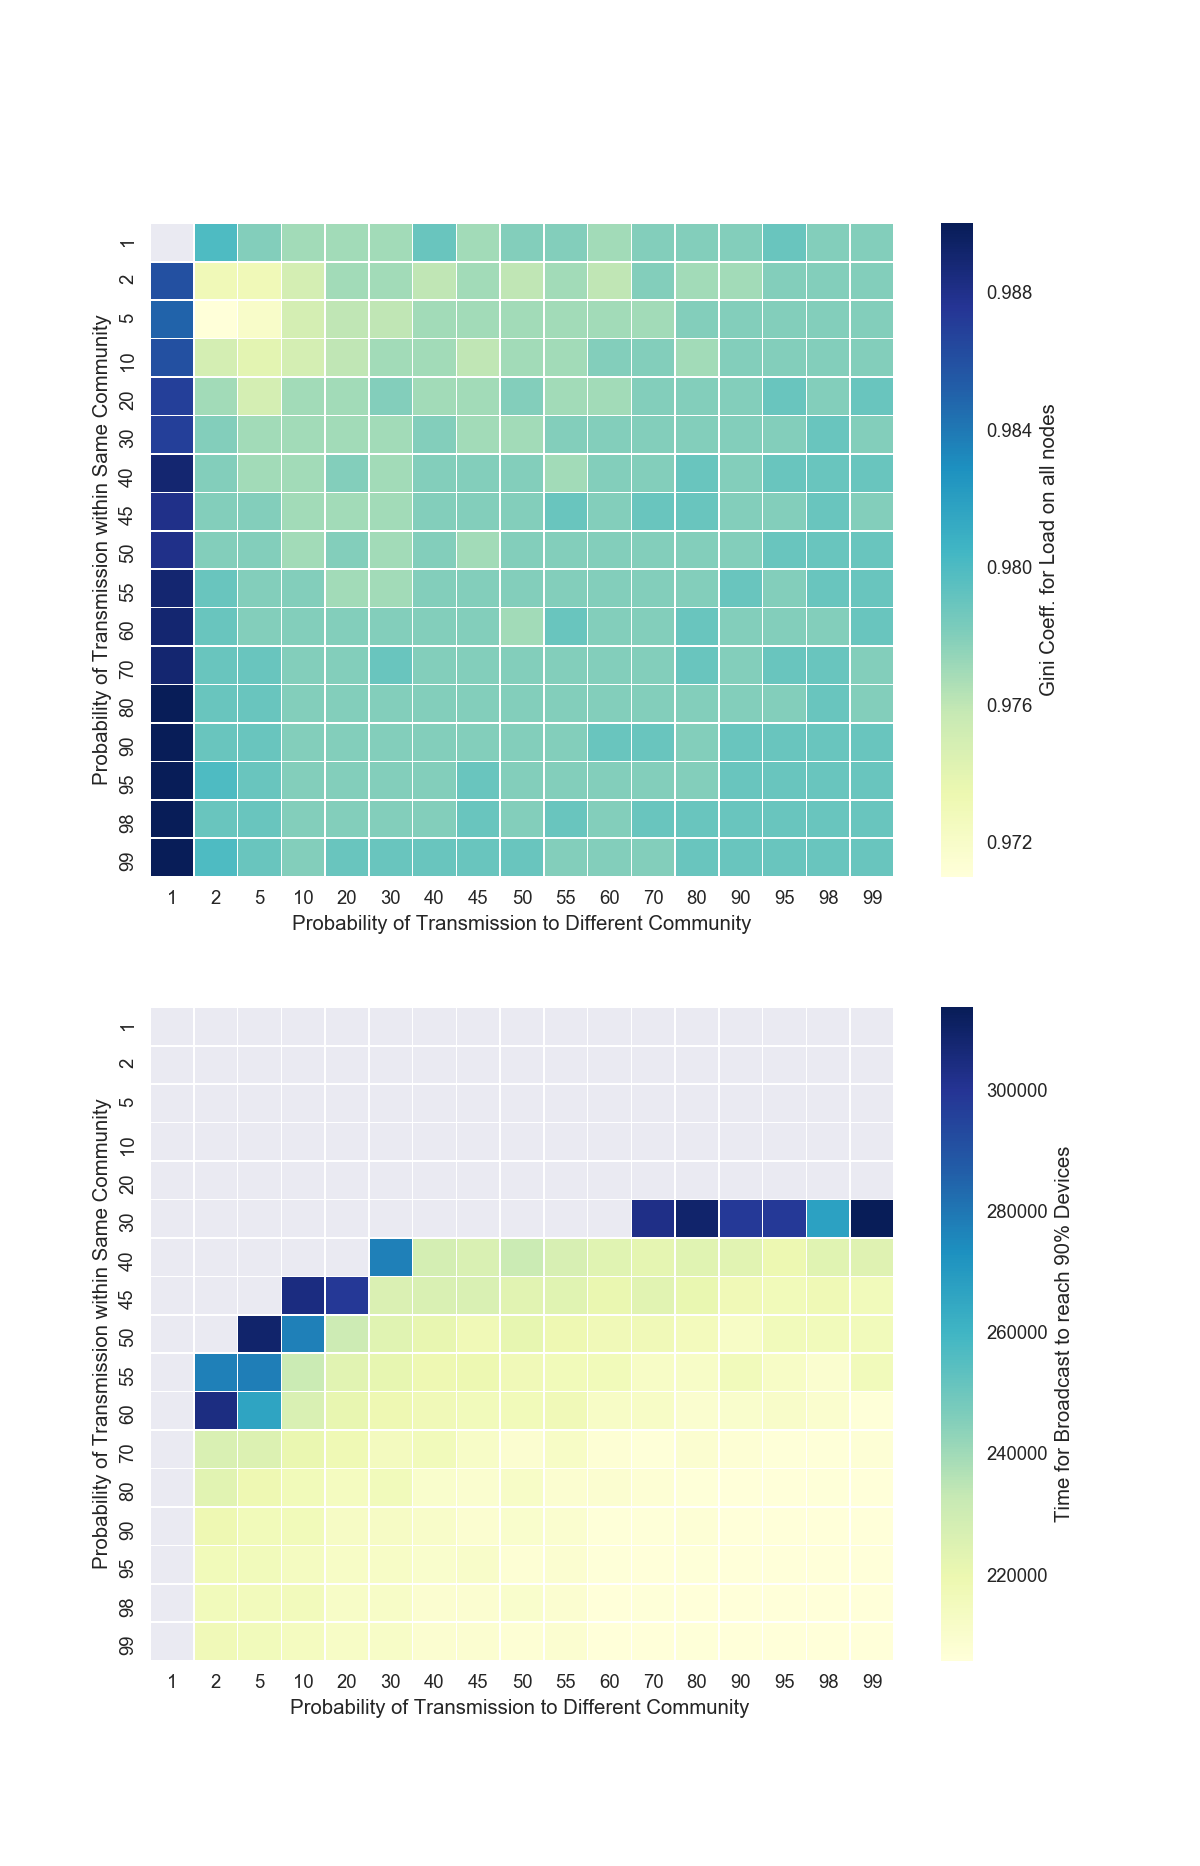

In [28]:
%matplotlib notebook

######### Broadcast Algorithm 3 - Analysis 3.a - Plot 1 ########
analysis_df_3a_pivot1 = analysis_df_3a.pivot('T_Prob_Same','T_Prob_Diff','Gini_Load')
analysis_df_3a_pivot2 = analysis_df_3a.pivot('T_Prob_Same','T_Prob_Diff','Time_90')
inf_mask = np.isinf(analysis_df_3a_pivot2)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(9,14),sharey='all')
sns.heatmap(analysis_df_3a_pivot1,cmap="YlGnBu",linewidths=.3,ax=ax1,cbar_kws={"orientation": "vertical","label":"Gini Coeff. for Load on all nodes"})
ax1.set_xlabel("Probability of Transmission to Different Community")
ax1.set_ylabel("Probability of Transmission within Same Community")
sns.heatmap(analysis_df_3a_pivot2,vmin=np.min(np.min(analysis_df_3a_pivot2[~inf_mask])),vmax=np.max(np.max(analysis_df_3a_pivot2[~inf_mask])),mask=inf_mask,cmap="YlGnBu",linewidths=.3,ax=ax2,cbar_kws={"orientation": "vertical","label":"Time for Broadcast to reach 90% Devices"})
ax2.set_ylabel("Probability of Transmission within Same Community")
ax2.set_xlabel("Probability of Transmission to Different Community ")
plt.show()
################################################################

In [29]:
######## Broadcast Algorithm 3 - Analysis 3.b ########
### Uncomment only to change the source device IDs (This needs the analysis to be redone)
# source_ids_idx = random.sample(range(devices.shape[0]),100)
# source_ids_idx_df = pd.DataFrame(data=source_ids_idx,columns=['id'])
# source_ids_idx_df.to_csv('data/id_3.csv',index=False)

source_ids_idx = list(pd.read_csv('data/id_3.csv')['id'])
source_ids = list(devices.iloc[source_ids_idx].index)
x_list = np.array([1,2,5,10,20,30,40,45,50,55,60,70,80,90,95,98,99])
analysis_df_3b = pd.DataFrame(columns=['T_Prob_Diff','T_Prob_Same','Mean_Gini_Load',"Above 90% Reach",'Time_90_Mean','Time_90_Std','Chunk Copies','% Devices Reached'])

### Uncomment only to recalculate entire analysis
# for idx, x in enumerate(x_list):
#     gini_l, time_90, chunk_copies, dev_reached = [], [], [], []
#     for idd, source_id in enumerate(source_ids):
#         g, t, chnk, dev = broadcast_3(devices,source_id,x,y)
#         if(t != np.inf): time_90.append(t)
#         gini_l.append(g)
#         chunk_copies.append(chnk)
#         dev_reached.append(dev)
#     analysis_df_3b.loc[idx] = [x,100-x,np.nanmean(gini_l),len(time_90),np.mean(time_90),np.std(time_90),np.mean(chnk),np.mean(dev_reached)]
#     print(list(analysis_df_3b.loc[idx]))

# analysis_df_3b.to_csv('out/Analysis_3b.csv',index=False)

analysis_df_3b = pd.read_csv('out/Analysis_3b.csv')
######################################################

<IPython.core.display.Javascript object>


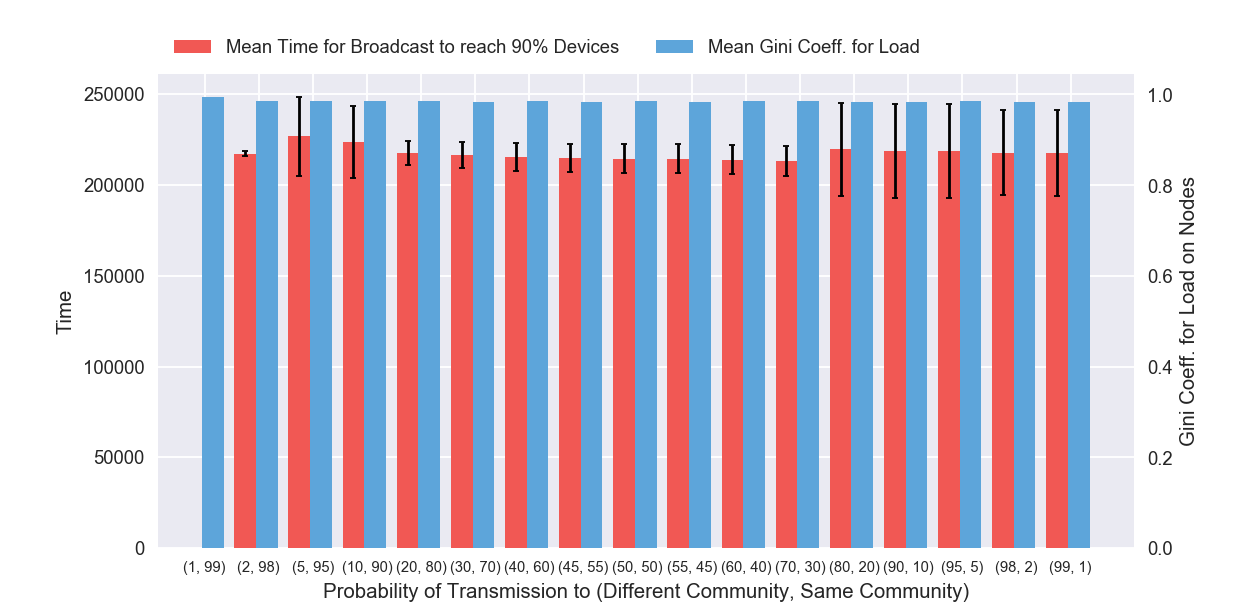

In [30]:
%matplotlib notebook

######### Broadcast Algorithm 3 - Analysis 3.b - Plot 2 ########
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.grid()
x = np.arange(analysis_df_3b['T_Prob_Diff'].shape[0])
r1 = ax1.bar(x,analysis_df_3b['Time_90_Mean'],width=0.4,color='#F15854',yerr=analysis_df_3b['Time_90_Std'],error_kw=dict(lw=1.5,capsize=1.5,capthick=1))
r2 = ax2.bar(x+0.4,analysis_df_3b['Mean_Gini_Load'],width=0.4,color='#5DA5DA')
ax1.set_xticks(x+0.25)
ticklabels = [(a,b) for a,b in zip(list(analysis_df_3b['T_Prob_Diff']),list(analysis_df_3b['T_Prob_Same']))]
ax1.set_xticklabels(ticklabels,fontsize=8)
ax1.set_xlabel('Probability of Transmission to (Different Community, Same Community)')
ax1.set_ylabel('Time')
ax2.set_ylabel('Gini Coeff. for Load on Nodes')
ax1.legend((r1[0],r2[0]),('Mean Time for Broadcast to reach 90% Devices','Mean Gini Coeff. for Load'),bbox_to_anchor=(0,1),loc=3,ncol=2)
plt.show()
################################################################